## Introduction
In this version, file 'PreliminaryResults_8q.csv' is used, with a dataset containing the results in the preliminary minitest by the 40 participants. This analysis is performed in addition to the main analysis (the 21-question diagnostic completed by 87 students). 
The reason is that four of the participants did not complete the diagnostic prior to the experiment, and therefore their ability could not be estimated. Two possible solutions for this were proposed: 1) to apply the mean of the ability to those participants, and 2) to estimate their ability with the preliminary minitest in the experiment. This Jupyter notebook implements the latter.
Notes:
1) the order of the questions in the source file is exactly the same used in the experiment. This means:
        Experiment QID   Diagnostic QID
        1   10
        2   21
        3   6
        4   17
        5   16
        6   20
        7   8
        8   9
2) the parameters are set for 2-option questions.


In [1]:
import pandas as pd

# Load the data
file_path = 'PreliminaryResults_8q.csv'
data = pd.read_csv(file_path, index_col=0)

# Drop the first column (subject labels) from the data
# data = data.drop(columns=data.columns[0])


# Example: Define theta as the mean response across items
data.head()

C:\Users\pablo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8
SUBJECT,,,,,,,,
S1,1,0,0,0,1,1,1,1
S2,0,1,0,1,0,1,1,1
S3,1,1,1,0,0,1,1,1
S4,0,1,1,0,1,1,1,1
S7,0,1,1,1,0,0,1,0


In [2]:
# Define ability estimates (theta) for each student as initial guess (e.g., average score)
theta = data.mean(axis=1).values

# Assume binary response for simplicity (1 = correct, 0 = incorrect)
responses = data.values  # Convert DataFrame to numpy array for easier manipulation
print(theta)

[0.625 0.625 0.75  0.75  0.5   0.375 0.875 0.5   1.    0.125 0.375 0.5
 0.625 0.875 0.875 0.5   0.625 0.75  0.75  0.625 0.375 0.625 0.375 0.625
 0.625 0.375 0.5   0.75  0.25  0.625 0.75  0.5   0.375 0.75  0.5   0.5
 0.75  1.    0.5   0.5  ]


In [3]:
import numpy as np
from scipy.optimize import minimize

def three_pl_model(theta, a, b, c):
    return c + (1 - c) / (1 + np.exp(-a * (theta - b)))


In [4]:
def log_likelihood(params, *args):
    theta, responses = args
    a, b, c = params
    prob = three_pl_model(theta, a, b, c)
    
    # Avoid log(0) by clipping probabilities
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Regularization to penalize large a (high discrimination)
    penalty = 0.1 * (a - 1)**2  # Penalize deviation of a from 1
    
    return -np.sum(responses * np.log(prob) + (1 - responses) * np.log(1 - prob)) + penalty


# Store the estimated parameters
item_parameters = []

for i in range(responses.shape[1]):
    initial_params = [1.0, 0.0, 0.5]  # a, b, c
    """Difficulty bounds were set to +-2.8. This was so because setting higher bounds made a difference only in 4 items (2, 3, 5 and 11). 
    The reasonably minimum bound is 2.8 because the the highest easiness below 2.8 was item 14 (2.755) """
    
    # Adding bounds to ensure valid parameter estimates
    bounds = [(0.01, 4.5),  # a: discrimination should be positive
              (-3, 3),      # b: difficulty can vary widely
              (0.375, 0.45)]  # c: guessing should be between 0 and 1

    # Optimize with bounds
    result = minimize(log_likelihood, initial_params, args=(theta, responses[:, i]), bounds=bounds)
    item_parameters.append(result.x)

# Convert to a DataFrame for easier interpretation
item_params_df = pd.DataFrame(item_parameters, columns=['a', 'b', 'c'])
item_params_df

,a,b,c
0,1.704288,0.671563,0.434997
1,3.438783,0.676911,0.375000
2,4.134178,0.822951,0.375000
3,3.553215,1.036058,0.375000
4,2.369038,0.617487,0.375000
5,4.262349,0.625402,0.375000
6,3.617548,0.655705,0.375000
7,2.246592,0.834186,0.375000


In [5]:
import numpy as np

# Calculate total log-likelihood for all items
total_log_likelihood = 0

for i in range(responses.shape[1]):  # for each item
    a, b, c = item_parameters[i]
    prob = three_pl_model(theta, a, b, c)
    prob = np.clip(prob, 1e-6, 1 - 1e-6)  # Avoid log(0)
    
    # Calculate log-likelihood for this item
    item_log_likelihood = np.sum(responses[:, i] * np.log(prob) + (1 - responses[:, i]) * np.log(1 - prob))
    total_log_likelihood += item_log_likelihood

# Total number of parameters: 3 per item
num_parameters = responses.shape[1] * 3  
num_responses = responses.size  # Total number of responses (students * items)

# Calculate AIC and BIC
aic = 2 * num_parameters - 2 * total_log_likelihood
bic = np.log(num_responses) * num_parameters - 2 * total_log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

AIC: 434.51
BIC: 524.95


In [6]:
theta


array([0.625, 0.625, 0.75 , 0.75 , 0.5  , 0.375, 0.875, 0.5  , 1.   ,
       0.125, 0.375, 0.5  , 0.625, 0.875, 0.875, 0.5  , 0.625, 0.75 ,
       0.75 , 0.625, 0.375, 0.625, 0.375, 0.625, 0.625, 0.375, 0.5  ,
       0.75 , 0.25 , 0.625, 0.75 , 0.5  , 0.375, 0.75 , 0.5  , 0.5  ,
       0.75 , 1.   , 0.5  , 0.5  ])

In [7]:
item_parameters

[array([1.70428796, 0.67156306, 0.4349974 ]),
 array([3.43878334, 0.67691114, 0.375     ]),
 array([4.13417791, 0.82295126, 0.375     ]),
 array([3.55321547, 1.03605756, 0.375     ]),
 array([2.36903826, 0.61748654, 0.375     ]),
 array([4.26234898, 0.62540219, 0.375     ]),
 array([3.6175483 , 0.65570494, 0.375     ]),
 array([2.2465916, 0.8341857, 0.375    ])]

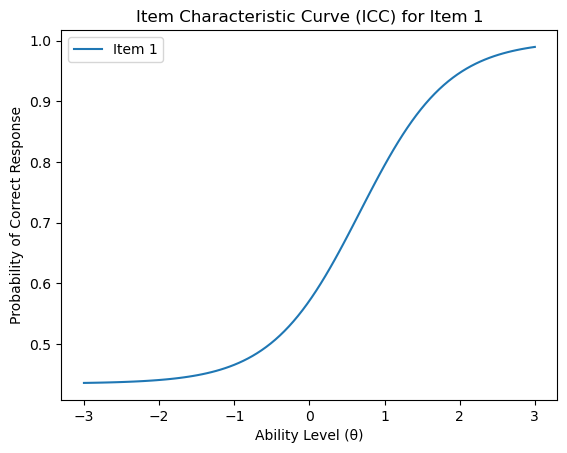

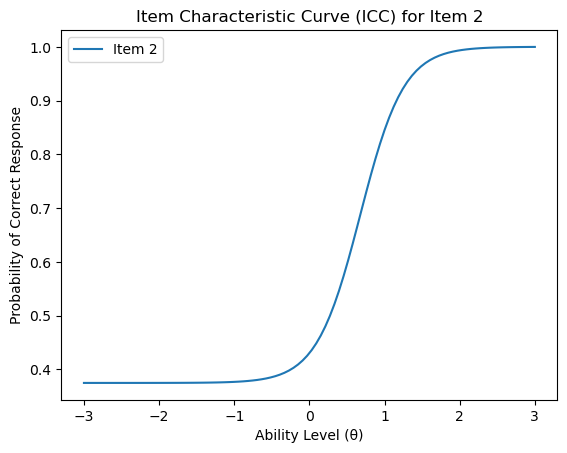

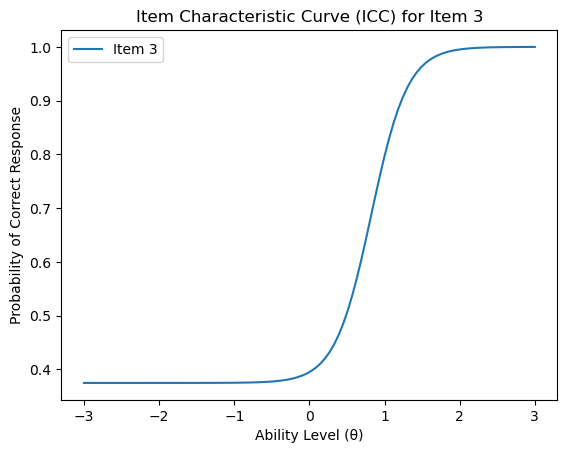

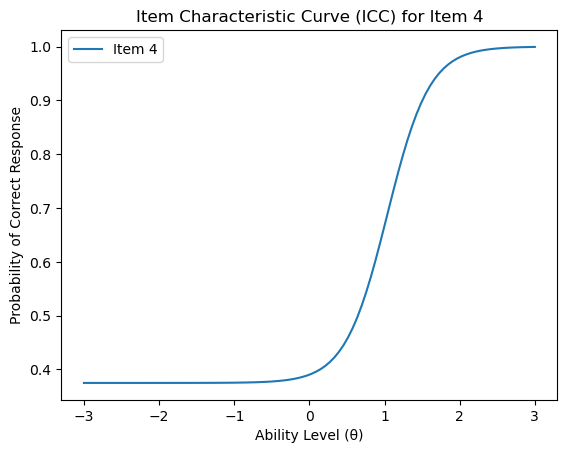

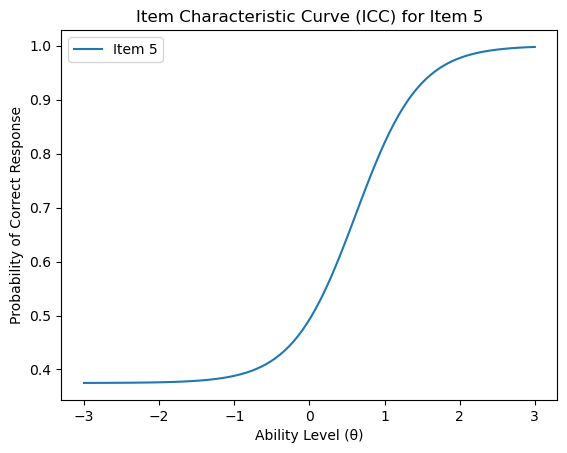

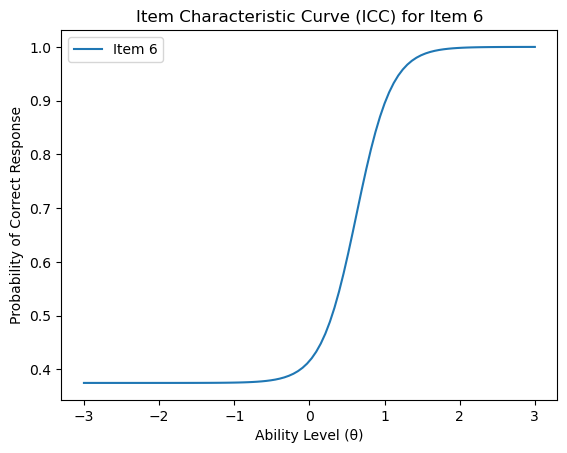

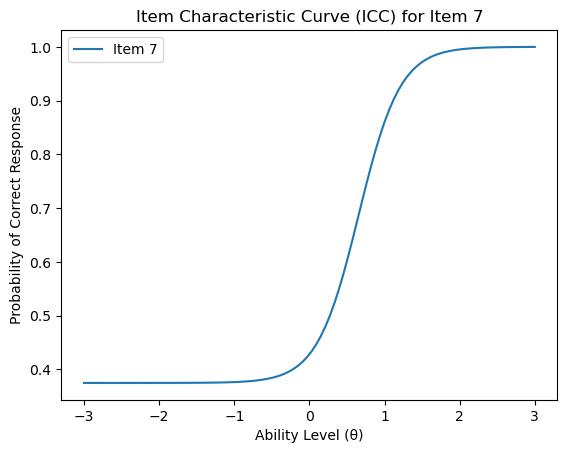

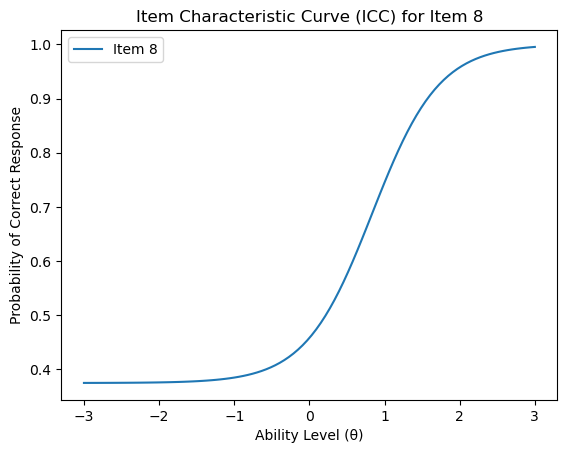

In [8]:
import matplotlib.pyplot as plt

theta_plot = np.linspace(-3, 3, 100)

# Use this theta_plot in the plotting code
for i, params in enumerate(item_parameters):
    a, b, c = params
    predicted_probabilities = three_pl_model(theta_plot, a, b, c)
    
    plt.plot(theta_plot, predicted_probabilities, label=f'Item {i+1}')
    plt.xlabel('Ability Level (θ)')
    plt.ylabel('Probability of Correct Response')
    plt.title(f'Item Characteristic Curve (ICC) for Item {i+1}')
    plt.legend()
    plt.show()


In [9]:
import numpy as np

# Function to compute the probability of a correct response given student's ability (theta)
def probability_correct(theta, a, b, c):
    """Calculate the probability of a correct response given ability (theta), discrimination (a), difficulty (b), and guessing (c)."""
    # Ensure stability by clamping the exponent within reasonable bounds
    exponent = np.clip(-a * (theta - b), -10, 10)
    return c + (1 - c) / (1 + np.exp(exponent))

# Function to estimate the ability (theta) using Maximum Likelihood Estimation (MLE)
def estimate_ability(response_vector, item_parameters, max_iterations=100, learning_rate=0.005, tolerance=1e-6):
    """Estimate the ability of a student using their response pattern and item parameters."""
    print("--------------- estimating ability----------------")
    
    print(response_vector)
    print(item_parameters)
    
    theta = 0  # Start with an initial guess of ability
    i=0
    for _ in range(max_iterations):
        gradient = 0
        hessian = 0
        
        # Calculate gradient and hessian for each item response
        for response, (a, b, c) in zip(response_vector, item_parameters):
            p_correct = probability_correct(theta, a, b, c)
            gradient += (response - p_correct) * (a)
            hessian += a * a * p_correct * (1 - p_correct)
            print(response, a, b, c, p_correct, gradient, hessian)
        
        # Update theta using gradient descent
        if abs(hessian) < tolerance:  # Prevent division by zero
            break
        theta_update = gradient / hessian
        # Clamp theta within a reasonable range to avoid divergence
        theta = np.clip(theta + learning_rate * theta_update, -5, 5)
        
        # Check for convergence
        if abs(theta_update) < tolerance:
            break
    print("theta:", theta)
    return theta

# Estimating abilities for each student using the updated approach
student_abilities = [estimate_ability(student_responses, item_parameters) for student_responses in responses]
print("Estimated Abilities:", student_abilities)

# Plotting the distribution of estimated abilities
import matplotlib.pyplot as plt

plt.hist(student_abilities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Estimated Ability (Theta)')
plt.ylabel('Number of Students')
plt.title('Distribution of Estimated Abilities')
plt.show()


--------------- estimating ability----------------
[1 0 0 0 1 1 1 1]
[array([1.70428796, 0.67156306, 0.4349974 ]), array([3.43878334, 0.67691114, 0.375     ]), array([4.13417791, 0.82295126, 0.375     ]), array([3.55321547, 1.03605756, 0.375     ]), array([2.36903826, 0.61748654, 0.375     ]), array([4.26234898, 0.62540219, 0.375     ]), array([3.6175483 , 0.65570494, 0.375     ]), array([2.2465916, 0.8341857, 0.375    ])]
1 1.7042879633094867 0.6715630624890075 0.43499739584372177 0.5714389509706547 0.730391437404 0.7113256834388703
0 3.438783336715899 0.6769111403446715 0.375 0.4305316159954724 -0.7501135096105987 3.6105665270234284
0 4.134177905208621 0.8229512610332165 0.375 0.3951412127381056 -2.383697580749814 7.6954967827481475
0 3.553215470857702 1.036057557703549 0.375 0.39035649670745365 -3.770718324000552 10.700053803859388
1 2.369038264300799 0.6174865398977434 0.375 0.4925199550272318 -2.5684786790909744 12.102825361717276
1 4.262348978714269 0.6254021876324606 0.375 0.415

0 3.438783336715899 0.6769111403446715 0.375 0.42716952987589785 -0.7326304015759555 3.6063159677879515
0 4.134177905208621 0.8229512610332165 0.375 0.3935998375324971 -2.359842153396508 7.685680753997382
0 3.553215470857702 1.036057557703549 0.375 0.38933351641485064 -3.7432280272451863 10.687392367158436
0 2.369038264300799 0.6174865398977434 0.375 0.48809321292349916 -4.899539525206473 12.089682270962225
0 4.262348978714269 0.6254021876324606 0.375 0.41254039574734824 -6.657930659698563 16.49261954538443
0 3.617548299504466 0.6557049352966016 0.375 0.4249268919732865 -8.195124215170242 19.690527451006563
0 2.24659160374961 0.8341857049454707 0.375 0.4550025850742427 -9.217329202482404 20.942101556727184
1 1.7042879633094867 0.6715630624890075 0.43499739584372177 0.5675834476461044 0.7369623253125308 0.712882551512664
0 3.438783336715899 0.6769111403446715 0.375 0.426808823511772 -0.7307407449430678 3.6058431103166706
0 4.134177905208621 0.8229512610332165 0.375 0.39343635347201905 -

1 4.134177905208621 0.8229512610332165 0.375 0.4085380543195931 5.000671904672881 7.7644227302858395
0 3.553215470857702 1.036057557703549 0.375 0.39892423006550104 3.5832081587041458 10.791773370706142
0 2.369038264300799 0.6174865398977434 0.375 0.5244152726682589 2.3408483113693035 12.19151339680343
1 4.262348978714269 0.6254021876324606 0.375 0.44216751733846876 4.718525024135326 16.67265475474455
1 3.617548299504466 0.6557049352966016 0.375 0.4558763988456051 6.6869184322116535 19.91884037192853
0 2.24659160374961 0.8341857049454707 0.375 0.4813223601813436 5.605583659131302 21.1788731025006
1 1.7042879633094867 0.6715630624890075 0.43499739584372177 0.5956726053217803 0.6890903119863739 0.6995628662780778
1 3.438783336715899 0.6769111403446715 0.375 0.45771236095066276 2.5539000088562407 3.634724172480518
1 4.134177905208621 0.8229512610332165 0.375 0.40871212377065463 4.99838928238133 7.765149908228197
0 3.553215470857702 1.036057557703549 0.375 0.39903265766770396 3.58054026977

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
print("Estimated Abilities:", student_abilities)

Estimated Abilities: [0.07286142657137246, 0.13843328849946665, 0.18928650608521422, 0.20400042504174612, 0.08513426317840704, -0.07994786092641391, 0.24015492609971678, 0.05561078822512336, 0.31925207564700747, -0.2151989171199192, -0.1075348776949815, 0.07700009575485793, 0.09942144090305145, 0.2259637294171405, 0.27022934267019616, 0.061977722016575046, 0.13785954903112024, 0.23012704393878244, 0.23282257438044543, 0.1392970969851777, -0.052644526409895254, 0.0997304159869594, -0.1075348776949815, 0.11133760018287725, 0.07286142657137246, -0.06743168870520283, 0.03018635544858308, 0.16553442983775124, -0.15977572313833768, 0.08100101031028359, 0.16553442983775124, 0.07019762627768193, -0.07864709281788414, 0.14860957247069248, 0.05982844128994486, -0.009371346116676286, 0.17911710285799928, 0.31925207564700747, 0.018115515273448332, -0.024136151935932312]
